# Timeseries transformer for macroeconomic policy simulation

The core idea is to use **counterfactual shifts** to simulate macroeconomic scenarios based on changes in one key indicator variable $i$ - the conditioning variable $c$. That is to say, to determine the effectiveness of for example a central bank policy measured by $\textbf{x} = {x_1, x_2, ..., x_m}, \textbf{x} \subset X \land i \in X$ (with $\textbf{x} = X \setminus y$) when the exchange rate of a certain currency $i$ would have been different from that found in the real data (counterfactually shifting observed $i$ to simulated $c$ under macroeconomic scenario $s$), one needs to be able to model the effect of changes in variable $i$ on all other variables $\textbf{x}$ in the dataset $X$.

### Generative autoregressive conditional models

To formalize, the generative model needs to learn both the joint probability

$$ P(i_t,\textbf{x}_t) = P(X_{t-n:t-1}|i_{t-n:t-1},\textbf{x}_{t-n:t-1}), i \in X, \textbf{x} \subset X, i \notin \textbf{x}$$

of the conditioning variable $i$ and the conditioned variables $\textbf{x} \subset X$ at time $t$ conditional on previous timesteps ${t-n, ..., t-1}$, **and** the conditional probability of $\textbf{x}$ given $i$ at time $t$ conditioned on a macroeconomic scenario $s$, where $i_t^s = c_t$,

$$P(\textbf{x}_t|c_t)$$

From a Bayesian point of view, it makes sense to take the distribution in the real data as the prior. This means that the model needs to
1. Approximate the $n$ historical autoregressive priors for all variables $p(X_t|X_{t-n:t-1})$ at $X_t$ given $X_{t-n}, ..., X_{t-1}$.
2. Infer the posterior distribution $p(X_{t-n:t-1},\beta,\gamma|X_t) \propto p(X_t|X_{t-n:t-1},\beta,\gamma)p(X_t|X_{t-n:t-1})$, where $\gamma$ maps contemporary relationships between variables at time $t$ and $\beta$ models the autoregressive relationship over time for all variables, mapping $X_{t-n:t-1}$ on to $X_t$.
3. Use the inferred posterior of the variables $\textbf{x}$ to generate $Y = c,P(\textbf{x}|c,s,\beta,\gamma)$, where $c$ is the conditioned form of $i$ shifted to simulate some explicitly programmed counterfactual scenario $s$, and $P(\textbf{x}|c,s)$ are the values of $\textbf{x}$ mapped onto this counterfactual scenario $s$. 

Given that a scenario $s$ can also be modeled as a regime, another promising research direction for macroeconomic policy simulation can be found RL research on the topic of policy switches in model-based RL.

## Timeseries transformer

The autoregressive model used in this notebook is an adaptation of the [transformer architecture](https://arxiv.org/abs/1706.03762) to timeseries generation. This neural network architecture has seen tremendous success both in [NLP](https://github.com/google-research/bert) and [music generation](https://magenta.tensorflow.org/music-transformer). At the time of starting this work, the transformer architecture had not been adapted for multivariate timeseries reconstruction and generation. This work aims to take advantage of the autoregressive propererties of transformer architecture to perform macroeconomic policy analysis and generate counterfactual timeseries based on conditional variables.

![Transformer architecture](images/illustrated_transformer.png)

<center>Transformer architecture (source: https://jalammar.github.io/illustrated-transformer/ )</center>

At the core of the transformer architecture is the idea of self-attention, which consists of multiplying the input matrix (the 'query' matrix $Q$) with its transpose (the 'key' matrix $K$), optimizing the resulting product in a linear softmax layer and multiplying the result with the input again (the 'value' matrix $V$) (from [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf), p. 4):

$$Attention(Q, K, V) = softmax(QK^T/\sqrt{d_k)})V$$

In this implementation of the attention mechanism dividing the result of $QK^T$ by the model dimension $d_k$ is done to scale the output of the attention matrix. Please consult the referenced resources for more detailed information on the transformer architecture.

#### Timeseries adaptation: embedding the sequence in historical data

In the original applications of the transformer to the natural language processing (NLP) domain, the block matrix operations on inputs $Q$, $K$ and $V$ are made possible by embedding language tokens in word, character or word-piece embeddings. The continuous values present in timeseries make the embedding approach less interesting. Although bucketing continous values is in theory a viable approach, there would be an enormous loss of information resulting from the bucketing of continuous variables. Furthermore, the bucketing would need to be done before the actual training of the model through manual feature engineering, whereas most modern neural network successes have originated in the end-to-end training of both the feature representation and statistical model in a single pass. Because of these considerations, the approach taken in this notebook was to use historical data as the 'embedding' of the multivariate data at time $t$.

The input of the model at training time consists of the following sets of multivariate arrays:

|  input             |  description                                                          |
|--------------------|-----------------------------------------------------------------------|
| `source`           | the multivariate array of macroeconomic indicators at timestep $t-1$. |
| `source history`   | the matrix of multivariate arrays at timesteps $t-(1+n)$ until $t-1$. |
| `target`           | the multivariate array of macroeconomic indicators at timestep $t$.   |
| `target history`   | the matrix of multivariate arrays at timesteps $t-n$ until $t$.       |
| `label`            | the variable of interest at time $t$.                                 |


In addition to the adaptation to timeseries, the transformer architecture was extended with batch normalization layers to address covariate shift (c.f. [Johansson et al. 2018](https://arxiv.org/abs/1605.03661)) and improve generalization across datasets. 


### Counterfactuals

From a causal inference standpoint, policy simulations should result in an estimate of either individual treatment effects ($ITE_i = Y_1^{(i)} - Y_0^{(i)}$ for treatment (1) and non-treatment (0) conditions on unit $i$), or average treatment effects ($ATE = 1/N \sum\limits_i y_1(i) - y_0(i)$) of the policy intervention $c$ on the other variables $\textbf{x}$.

In the language of causal analysis, the factual variable $i$ and counterfactual variable $c$ under scenario $s$ are investigated. Therefore the generator should learn to model not only the generated variables but also underlying confounders, which are hypothesized to aid in generating more realistic simulations.

### Training and inference

The model is trained to generate datapoints conditional both on $\textbf{A}$) previous timesteps ${t-n, ..., t-1}$ and $\textbf{B}$) autoregressive lateral relationships between variables (longitudinal and contemporary effects), ignoring $\textbf{C}$) the conditional variable $c$ during training. During inference $c$ is modified artificially to simulate the counterfactual condition $\textbf{C}$), letting the simulator model render the effect of $c$ on the $x \subset X$ variable of interest.

The model learns to predict variables $\textbf{i}_t = \textbf{x}_t$ at time $t$ given $\textbf{x}_{t-1}$ within the context of $\textbf{x}_{t-n:t-1}$. For practical purposes the data feed consists of multivariate sequences of length $n-1$, $n$ historical observations of that multivariate array, and a variable of interest of size $1$. During inference, the model needs to have access to predictions at it made at previous timesteps in order to set the generated context $\hat{\textbf{x}}_{t-n:t-1}$.

###### Reconstruction and counterfactual loss

The correctness of the generator can be measured by proxy by looking at **reconstruction losses** from historical data. I.e., provide it with a prompt of $m$ sequences on unseen historical country data, and determine how close it matched the real data for the remaining $n-m$ observations. Given the natural differences in country data, it might be good to take a pool of representative countries as the validation dataset.

The problem of reconstruction loss measurement in generative models is compounted in counterfactual simulations where the loss metric cannot be measured directly from labeled data. A proxy of **counterfactual loss** could be to measure the proportional, variable-bound divergence of the simulated data from the real distribution, for example through Kullback-Leibler divergence, Fisher information, or optimal transport. The assumption underlying such an approach would be that of *real-world constraints* on macroeconomic data, i.e. the overall quantities of the indicator variable won't change as a result of counterfactual evidence, but their underlying distribution might.

One widely-used metric is maximum-mean discrepancy (MMD, c.f. [Gretton et al., 2012](http://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf), [Sutherland et al., 2107](https://arxiv.org/abs/1611.04488)), which can be estimated empirically over the means of the real and simulated data distributions. In the current approach, maximum-mean discrepancy (MMD) loss is implemented in addition to mean squared error (MSE) loss in order to improve the generalization properties of the generative model.

In [1]:
import os
import mlflow
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format
pd.options.display.max_columns = 50

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [4]:
tf.__version__

'2.2.0'

In [5]:
mlflow.set_experiment("tt-loss-functions")

#### Load and prepare the data

In [6]:
country = 'Switzerland'

In [7]:
train_countries = ['Canada', 'Denmark', 'France', 'Germany', 'Japan', 'Netherlands', 'Norway', 'Singapore',
                   'Sweden', 'Switzerland', 'United Kingdom', 'United States']

In [8]:
train_countries.remove(country)

In [9]:
labels_df = pd.read_csv('features/timeseries-transformer/simulator_labels.csv', sep=';', header=0)

In [10]:
holdout_df = pd.read_csv('features/timeseries-transformer/%s_features.csv' % country, sep=';', header=0)

In [11]:
country_df = pd.concat([holdout_df, labels_df.drop(columns=['date'])], axis=1)

In [12]:
country_df.describe()

,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,population density,real interest rate,broad money,exports of goods and services,gross domestic savings,high-tech value added,household consumption expenditure,housing expenditure,health expenditure,education expenditure,leisure expenditure,imports of goods and services,listed companies,manufacturing value added,r and d spend,services trade,...,government debt service,government interest payments external debt,government tax revenue,birth deaths,broadband subscriptions,electricity access,co2 emissions,electricity consumption,mobile subscriptions,newborns,overweight,rural population,urban population,Canada,Denmark,France,Germany,Japan,Netherlands,Norway,Singapore,Sweden,Switzerland,United Kingdom,United States
count,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,...,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000,696.0000
mean,0.0131,0.0020,5.2228,0.6197,0.0363,0.1128,0.0102,0.0282,0.7734,0.1698,0.0179,0.8483,0.3361,0.2080,0.0494,0.3672,0.0618,0.0323,0.0013,0.0239,0.2881,0.9955,0.0918,0.0101,0.1307,...,0.0000,0.0000,0.6552,0.0013,0.0901,0.4828,5.6573,6.3732,0.3612,0.0127,0.2209,0.2642,0.7358,0.0380,0.0463,0.0421,0.0264,0.0309,0.0337,0.0455,0.0255,0.0443,0.0250,0.0522,0.0378
std,0.0247,0.0037,1.3306,0.1065,0.0127,0.1132,0.0170,0.0246,0.0371,0.0294,0.0172,0.6580,0.2623,0.1520,0.0530,0.2669,0.0712,0.0379,0.0016,0.0277,0.2224,0.9665,0.0952,0.0130,0.1171,...,0.0000,0.0000,0.4757,0.0011,0.1584,0.5001,0.7922,1.6739,0.5174,0.0029,0.1383,0.0076,0.0076,0.0296,0.0344,0.0367,0.0169,0.0399,0.0241,0.0313,0.0370,0.0358,0.0230,0.0476,0.0270
min,0.0000,0.0000,0.0000,0.4705,0.0000,0.0000,-0.0063,0.0000,0.7119,0.0000,-0.0105,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,3.6644,3.0756,0.0000,0.0098,0.0000,0.2552,0.7092,0.0017,0.0025,0.0004,-0.0013,-0.0135,-0.0069,0.0036,-0.0184,-0.0049,-0.0114,0.0005,-0.0036
25%,0.0000,0.0000,4.2569,0.5274,0.0281,0.0000,0.0000,0.0000,0.7429,0.1589,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,5.1857,5.0102,0.0000,0.0105,0.0000,0.2590,0.7345,0.0161,0.0203,0.0170,0.0153,0.0017,0.0168,0.0213,0.0058,0.0152,0.0076,0.0223,0.0203
50%,0.0000,0.0000,5.4615,0.5763,0.0342,0.1556,0.0007,0.0274,0.7723,0.1675,0.0226,1.0775,0.4111,0.2985,0.0000,0.5424,0.0000,0.0000,0.0000,0.0000,0.3607,0.7203,0.0000,0.0000,0.1196,...,0.0000,0.0000,1.0000,0.0008,0.0000,0.0000,5.7903,7.1836,0.0078,0.0117,0.2752,0.2631,0.7368,0.0254,0.0321,0.0275,0.0215,0.0191,0.0258,0.0332,0.0164,0.0337,0.0177,0.0359,0.0298
75%,0.0000,0.0000,6.3004,0.7221,0.0401,0.2390,0.0210,0.0507,0.8054,0.1857,0.0315,1.3165,0.5430,0.3187,0.1083,0.5703,0.1403,0.0755,0.0030,0.0532,0.4737,2.0326,0.1894,0.0245,0.2650,...,0.0000,0.0000,1.0000,0.0016,0.1075,1.0000,6.2242,7.6467,0.8488,0.0133,0.3327,0.2655,0.7410,0.0462,0.0671,0.0563,0.0350,0.0527,0.0461,0.0686,0.0303,0.0722,0.0379,0.0626,0.0463
max,0.0729,0.0129,7.0451,0.8228,0.0647,0.2708,0.0735,0.0783,0.8320,0.2142,0.0556,1.9000,0.7470,0.3587,0.1287,0.5859,0.1536,0.0903,0.0046,0.0623,0.6148,2.9123,0.2049,0.0297,0.3272,...,0.0000,0.0000,1.0000,0.0039,0.4542,1.0000,7.3348,8.3606,1.3585,0.0195,0.3635,0.2908,0.7448,0.1247,0.1528,0.1365,0.0703,0.2322,0.1022,0.1364,0.2237,0.1371,0.0977,0.2421,0.1355


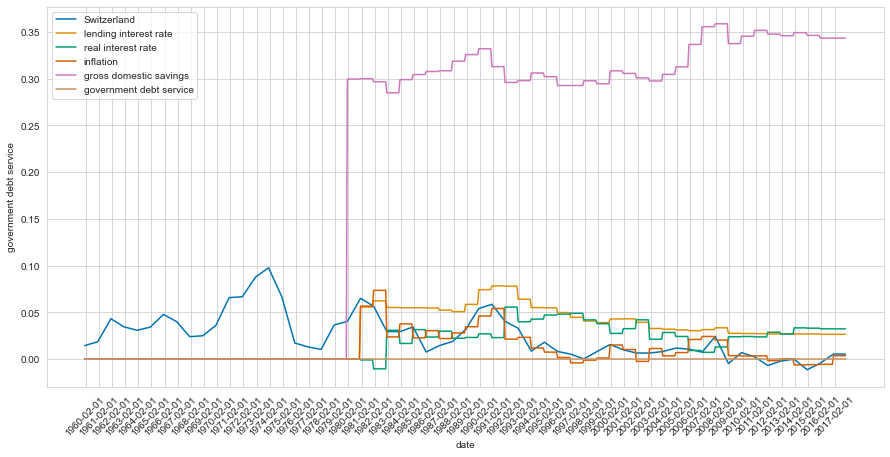

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=country_df) for c in list([country, 'lending interest rate', 'real interest rate', 'inflation', 'gross domestic savings', 'government debt service'])]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(country_df['date'], rotation=45);

In [14]:
country_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'housing expenditure', 'health expenditure', 'education expenditure',
       'leisure expenditure', 'imports of goods and services',
       'listed companies', 'manufacturing value added', 'r and d spend',
       'services trade', 'trade', 'government debt service',
       'government interest payments external debt', 'government tax revenue',
       'birth deaths', 'broadband subscriptions', 'electricity access',
       'co2 emissions', 'electricity consumption', 'mobile subscriptions',
       'newborns', 'overweight', 'rural population', 'urban population',
       'C

In [15]:
cols = ['date', 'bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
        'energy imports', 'food exports', 'high-tech exports', 'inflation',
        'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
        'broad money', 'exports of goods and services', 'gross domestic savings',
        'high-tech value added', 'household consumption expenditure', 'housing expenditure', 
        'health expenditure', 'education expenditure', 'leisure expenditure',
        'imports of goods and services', 'listed companies', 'manufacturing value added',
        'r and d spend', 'services trade', 'trade', 'government debt service',
        'government interest payments external debt', 'government tax revenue', 'birth deaths',
        'broadband subscriptions', 'electricity access', 'co2 emissions',
        'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
        'rural population', 'urban population']

In [16]:
base_feature_df = country_df[cols + [country]]

In [17]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);
base_df.set_index('date');

The following feature groups are used in the simulation:

* **finance**: bank nonperforming loans, lending interest rate, ..
* **consumption behaviour**: gross domestic savings, household consumption expenditure, ..
* **quality of life**: life expectancy, births-to-deaths ratio, electricity access, broadband subscriptions, ..
* **trade**: exports of goods and services, imports of goods and services, services trade, trade, ..
* **governance**: government tax revenue, government debt service, ..

In [18]:
model_cols = ['bank nonperforming loans', 'lending interest rate', 'gross domestic savings', 'inflation',
              'household consumption expenditure', 'housing expenditure', 'health expenditure',
              'education expenditure', 'leisure expenditure', 'exports of goods and services',
              'imports of goods and services', 'energy imports', 'services trade', 'trade', 
              'life expectancy', 'electricity access', 'electricity consumption', 'birth deaths',
              'broadband subscriptions', 'co2 emissions', 'government tax revenue', 'government debt service',
              'broad money', 'listed companies', 'manufacturing value added', 'r and d spend', 'label']

In [19]:
factual_df = base_df[model_cols]
factual_df.shape

(696, 27)

In [20]:
num_variables = len(factual_df.columns) - 1

### Timeseries transformer features

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
params = {
   'country': country,
   'num_epochs': 15,
   'warmup_stop': 2,
   'save_interval': 3,
   'num_timesteps': 4,
   'num_variables': num_variables,
   'tar_mask_pct': 0.15,
   'batch_size': 32,
   'num_layers': 2,
   'd_model': 256,
   'dff': 512,
   'num_heads': 4,
   'dropout_rate': 0.1,
   'mlp_num_layers': 256,
   'lr': 0.1,
   'optimizer': 'adam',
   'simulation_loss': 'maximum_mean_discrepancy',
   'simulation_loss_weight': 4,
   'prediction_loss': 'mean_squared_error',
   'prediction_loss_weight': 1 
}

In [23]:
def tt_data(num_obs, num_variables, num_timesteps, tt_df):
    """
       Prepare the input data for the timeseries transformer
         * src           the macroeconomic indicator variables of the input timestep at time t
         * src history   the t - 'num_timesteps' timestep history of the src input
         * tar           the t + 1 macroeconomic indicator variables array
         * tar history   the t + 1 - 'num_timesteps' timestep history of the tar input
         * label         the t + 1 variable of interest
    """
    src_vars = []
    src_hist_vars = []
    tar_vars = []
    tar_hist_vars = []
    labels = []
    
    variable_df = tt_df.drop(['label'], axis=1)
    
    for t in range(int(num_obs)):
        src_vars.append(variable_df[(t+num_timesteps):(t+num_timesteps+1)].values)
        src_hist_vars.append(variable_df[t:(t+num_timesteps)].values)
        tar_vars.append(variable_df[(t+num_timesteps+1):(t+num_timesteps+2)].values)
        tar_hist_vars.append(variable_df[t+1:(t+num_timesteps+1)].values)
        labels.append(tt_df['label'][(t+num_timesteps+1):(t+num_timesteps+2)].values)
        
    n = num_obs - (num_timesteps + 1)
    
    src_input = np.asarray(src_vars[0:n])
    src = src_input.reshape((n, num_variables, 1))
    src_history_input = np.asarray(src_hist_vars[0:n])
    src_history = src_history_input.reshape((n, num_variables, num_timesteps))
    tar_input = np.asarray(tar_vars[0:n])
    tar = tar_input.reshape((n, num_variables, 1))
    tar_history_input = np.asarray(tar_hist_vars[0:n])
    tar_history = tar_history_input.reshape((n, num_variables, num_timesteps))
    y_input = np.asarray(labels[0:n])
    y = y_input.reshape((n, 1))
    
    return src, src_history, tar, tar_history, y

In [24]:
def train_dataprep(cols, model_cols, num_variables, num_timesteps, countries, mask_pct):
    srcs = []
    srcs_hist = []
    tgts = []
    tgts_hist = []
    lbls = [] 

    for train_country in countries:
        # Prepare the country dataframe with time-shift labels
        country_features_df = pd.read_csv('features/timeseries-transformer/%s_features.csv' % train_country, sep=';', header=0)
        train_country_df = pd.concat([country_features_df, 
                                      labels_df.drop(columns=['date'])], axis=1)[cols+[train_country]]
        train_country_df['label'] = train_country_df[train_country].shift(periods=1)
        base_train_df = train_country_df.drop(train_country, axis=1).fillna(0.00);
        base_train_df.set_index('date');
        train_df = base_train_df[model_cols]
        
        # Prepare the data for the time series transformer
        s, s_hist, t, t_hist, y = tt_data(len(train_df), num_variables, params['num_timesteps'], train_df)
        
        srcs.append(s)
        srcs_hist.append(s_hist)
        tgts.append(t)
        tgts_hist.append(t_hist)
        lbls.append(y)
        
    n_obs = len(countries) * len(lbls[0])
    
    srcs_input = np.asarray(srcs)
    srcs_arr = srcs_input.reshape((n_obs, num_variables, 1))
    srcs_hist_input = np.asarray(srcs_hist)
    src_hist_arr = srcs_hist_input.reshape((n_obs, num_variables, num_timesteps))
    tars_input = np.asarray(tgts)
    tar_arr = tars_input.reshape((n_obs, num_variables, 1))
    tar_masked = np.array(tar_arr, copy=True)
    mask_idx = np.random.choice([True, False], (tar_masked.shape[0], tar_masked.shape[1]), replace=True,
                               p=[mask_pct, 1-mask_pct])
    tar_masked[mask_idx] = 0.0
    tars_hist_input = np.asarray(tgts_hist)
    tar_hist_arr = tars_hist_input.reshape((n_obs, num_variables, num_timesteps))
    lbls_input = np.asarray(lbls)
    y_arr = lbls_input.reshape((n_obs, 1))
    
    return srcs_arr, src_hist_arr, tar_arr, tar_masked, tar_hist_arr, y_arr

In [25]:
train_src, train_src_history, train_tar, train_tar_masked, train_tar_history, train_y = train_dataprep(
    cols, model_cols, num_variables, params['num_timesteps'], train_countries, params['tar_mask_pct'])

In [26]:
src, src_history, tar, tar_history, y = tt_data(len(factual_df), num_variables, params['num_timesteps'], factual_df)

In [27]:
n = len(factual_df) - (params['num_timesteps'] + 1)

## Timeseries transformer

The implementation of the Transformer network is adapted to timeseries generation from [the TensorFlow transformer tutorial](https://www.tensorflow.org/beta/tutorials/text/transformer) on neural machine translation.

In [28]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [29]:
def positional_encoding(num_positions, d_model):
    angle_rads = get_angles(np.arange(num_positions)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [30]:
def scaled_dot_product_attention(q, k, v):
    matmul_qk = tf.matmul(q, k, transpose_b=True) 
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
          
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
      
    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]
      
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
      
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size) 
        v = self.split_heads(v, batch_size) 

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
    
        output = self.dense(concat_attention)
        return output, attention_weights

In [32]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [33]:
class TimeseriesEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1, epsilon=1e-5):
        super(TimeseriesEncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
    
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
      
    def call(self, inputs, x, training):
        attn_output, _ = self.mha(x, k=x, q=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [34]:
class TimeseriesDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1, epsilon=1e-5):
        super(TimeseriesDecoderLayer, self).__init__()
        self.d_model = d_model
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
    
        self.ffn = point_wise_feed_forward_network(d_model, dff)
     
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
      
      
    def call(self, inputs, history, x, training):
        attn1, attn_weights_block1 = self.mha1(x, k=history, q=inputs)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + inputs)
        
        attn2, attn_weights_block2 = self.mha2(x, k=history, q=out1)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

In [35]:
class TimeseriesEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1):
        super(TimeseriesEncoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_variables = num_variables
        self.num_timesteps = num_timesteps
        
        self.pos_encoding = positional_encoding(self.d_model * 4, self.d_model)        
        self.enc_layers = [TimeseriesEncoderLayer(d_model, num_heads, dff,
                                                  num_variables, num_timesteps, rate) for _ in range(num_layers)]
      
        self.dropout = tf.keras.layers.Dropout(rate)
            
    def call(self, inputs, history, training):
        x = tf.concat([inputs, history], axis=-1)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :self.num_variables, :self.num_timesteps+1]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](inputs, x=x, training=training)
        
        return x

In [36]:
class TimeseriesDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate=0.1):
        super(TimeseriesDecoder, self).__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_variables = num_variables
        self.num_timesteps = num_timesteps
        
        self.pos_encoding = positional_encoding(self.d_model * 2, self.d_model)
        self.dec_layers = [TimeseriesDecoderLayer(d_model, num_heads, dff, num_variables, num_timesteps, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
      
    def call(self, inputs, history, x, training):
        attention_weights = {}
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :self.num_variables, :self.d_model]
        
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](inputs, history=history, x=x, training=training)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x

In [37]:
class TimeseriesTransformer(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, num_variables, num_timesteps, batch_size, rate=0.1):
        super(TimeseriesTransformer, self).__init__()

        self.encoder = TimeseriesEncoder(num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate)
        self.reshape = tf.keras.layers.Reshape((num_variables, 1))
        self.decoder = TimeseriesDecoder(num_layers, d_model, num_heads, dff, num_variables, num_timesteps, rate)
        self.mask = tf.keras.layers.Masking(mask_value=0., input_shape=(1, num_variables))
    
    def call(self, inputs, src_hist=None, tar=None, tar_hist=None, training=False):
        enc_output = self.encoder(inputs, history=src_hist, training=training)
        x = self.reshape(inputs)
        x = tf.keras.layers.Add()([x, enc_output])
        masked_target = self.mask(tar)
        return self.decoder(masked_target, history=tar_hist, x=x, training=training)

### Build the timeseries transformer model

In [38]:
def learning_rate_schedule(epoch, lr, warmup_stop=params['warmup_stop']):
    if epoch > 0 and epoch < warmup_stop:
        return lr * epoch
    elif epoch >= warmup_stop:
        return lr * (warmup_stop / epoch)
    else:
        return lr

In [39]:
if os.path.exists('./output'):
    shutil.rmtree('./output/')

In [40]:
es = tf.keras.callbacks.EarlyStopping(monitor='simulation_loss', mode='min', patience=0)
lr = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule, verbose=0)
tb = tf.keras.callbacks.TensorBoard(log_dir='./output', histogram_freq=1, write_graph=True)

In [41]:
tf.keras.backend.clear_session()

In [42]:
def build_simulator(params, model_name='simulator'):
    src_input = tf.keras.Input(shape=(params['num_variables'], 1), name='src_input')
    src_hist_input = tf.keras.Input(shape=(params['num_variables'], params['num_timesteps']), name='src_hist_input')
    tar_input = tf.keras.Input(shape=(params['num_variables'], 1), name='tar_input')
    tar_hist_input = tf.keras.Input(shape=(params['num_variables'], params['num_timesteps']), name='tar_hist_input')
    
    transformer = TimeseriesTransformer(num_layers=params['num_layers'], num_heads=params['num_heads'], 
                                        d_model=params['d_model'], dff=params['dff'], 
                                        num_variables=params['num_variables'],
                                        num_timesteps=params['num_timesteps'], batch_size=params['batch_size'])
    decoded = transformer(src_input, src_hist=src_hist_input, tar=tar_input, tar_hist=tar_hist_input, training=True)
    flattened = tf.keras.layers.Flatten()(decoded)
    simulation_variables = tf.keras.layers.Dense(num_variables, name='simulation_variables')(flattened)
    simulated = tf.keras.layers.Reshape((params['num_variables'], 1), name='simulation')(simulation_variables)
    mlp = tf.keras.layers.Dense(params['mlp_num_layers'],
                                kernel_initializer='he_uniform',
                                activation='sigmoid', 
                                name='mlp')(flattened)
    prediction = tf.keras.layers.Dense(1, name='prediction')(mlp)
    simulator = tf.keras.Model(inputs=[src_input, src_hist_input, tar_input, tar_hist_input],
                               outputs=[simulated, prediction], name=model_name)
    simulator.summary()
    return simulator

In [43]:
def gaussian_radial_basis_kernel(y_true, y_pred):
    kernel = tf.expand_dims(y_true, 1)
    return tf.keras.backend.exp(-1.0 * tf.reduce_sum(tf.keras.backend.square(kernel - y_pred)))

In [44]:
def maximum_mean_discrepancy(y_true, y_pred):
    avg_disc_true = tf.reduce_mean(gaussian_radial_basis_kernel(y_true, y_true))
    avg_disc_pred = tf.reduce_mean(gaussian_radial_basis_kernel(y_pred, y_pred))
    avg_disc = tf.reduce_mean(gaussian_radial_basis_kernel(y_true, y_pred))
    return avg_disc_true - 2 * avg_disc + avg_disc_pred

In [45]:
def mmd_loss_fn(y_true, y_pred):
    mmd = maximum_mean_discrepancy(y_true, y_pred)
    return tf.maximum(1e-2, mmd)

In [46]:
def simulation_loss(y_true, y_pred):
    mmd_loss = mmd_loss_fn(y_true, y_pred)
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return mmd_loss + mse_loss

In [47]:
losses = {
    'simulation': simulation_loss, 
    'prediction': params['prediction_loss']
}

In [48]:
loss_weights = {
    'simulation': params['simulation_loss_weight'],
    'prediction': params['prediction_loss_weight']
}

In [49]:
simulator = build_simulator(params)
simulator.compile(params['optimizer'], loss=losses, loss_weights=loss_weights, metrics=['mse'])

Model: "simulator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
src_input (InputLayer)          [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
src_hist_input (InputLayer)     [(None, 26, 4)]      0                                            
__________________________________________________________________________________________________
tar_input (InputLayer)          [(None, 26, 1)]      0                                            
__________________________________________________________________________________________________
tar_hist_input (InputLayer)     [(None, 26, 4)]      0                                            
__________________________________________________________________________________________

In [50]:
with mlflow.start_run() as run:
    # Log the model training run parameters
    mlflow.log_params(params)

    # Train the model on other countries
    simulator.fit([train_src, train_src_history, train_tar_masked, train_tar_history],
                  {'simulation': train_tar, 'prediction': train_y}, validation_split=0.1, shuffle=True,
                  batch_size=params['batch_size'], epochs=params['num_epochs'], callbacks=[es, lr, tb])
    
    # Generate values for the country of interest
    simulator_generated_values = simulator.predict([src, src_history, tar, tar_history])
    generated_values = map(lambda v: v.flatten(), simulator_generated_values[0])
    generated_cpi = simulator_generated_values[1]
    cpi = factual_df[['label']][0:n].values
    
    # Compute simulator performance stats on country of interest factual data
    mlflow.log_metrics({
        'country_mse': np.sqrt(mean_squared_error(cpi, generated_cpi)),
        'mean_generated': np.mean(generated_cpi),
        'mean_observed': np.mean(cpi)
    })

Epoch 1/15
214/214 [==============================] - 56s 259ms/step - loss: 5.4545 - simulation_loss: 1.1204 - prediction_loss: 0.9729 - simulation_mse: 1.1104 - prediction_mse: 0.9729 - val_loss: 3.8190 - val_simulation_loss: 0.9545 - val_prediction_loss: 8.2137e-04 - val_simulation_mse: 0.9445 - val_prediction_mse: 8.2137e-04 - lr: 0.0010
Epoch 2/15
214/214 [==============================] - 54s 254ms/step - loss: 0.9284 - simulation_loss: 0.2318 - prediction_loss: 0.0013 - simulation_mse: 0.2218 - prediction_mse: 0.0013 - val_loss: 2.2720 - val_simulation_loss: 0.5678 - val_prediction_loss: 9.1529e-04 - val_simulation_mse: 0.5578 - val_prediction_mse: 9.1529e-04 - lr: 0.0010
Epoch 3/15
214/214 [==============================] - 54s 251ms/step - loss: 0.7168 - simulation_loss: 0.1789 - prediction_loss: 0.0013 - simulation_mse: 0.1689 - prediction_mse: 0.0013 - val_loss: 2.0816 - val_simulation_loss: 0.5202 - val_prediction_loss: 8.2731e-04 - val_simulation_mse: 0.5102 - val_predicti

In [51]:
generator_target = map(lambda v: v.flatten(), train_tar)
pd.DataFrame(generator_target).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
count,"7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000","7,601.0000"
mean,0.0038,0.0384,0.2052,0.0354,0.4108,0.0490,0.0074,0.0029,0.0199,0.2617,0.2365,-0.0476,0.1216,0.5884,0.6917,0.4653,8.0006,0.0011,0.0773,9.0808,0.7187,0.0000,0.4613,0.4760,0.0904,0.0085
std,0.0098,0.0432,0.1235,0.0381,0.2289,0.0703,0.0130,0.0062,0.0270,0.3157,0.2703,1.5046,0.1549,0.6084,0.2293,0.4988,5.9442,0.0011,0.1353,5.3109,0.4497,0.0000,0.5731,0.5273,0.0838,0.0118
min,0.0000,0.0000,0.0000,-0.0521,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-8.4348,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.1492,0.0094,0.3581,0.0000,0.0000,0.0000,0.0000,0.0962,0.1065,0.0000,0.0000,0.2569,0.7322,0.0000,4.4031,0.0004,0.0000,6.2173,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0198,0.2356,0.0241,0.5078,0.0000,0.0000,0.0000,0.0000,0.1944,0.1925,0.2660,0.0962,0.5080,0.7603,0.0000,6.5341,0.0008,0.0000,9.2796,1.0000,0.0000,0.3609,0.3505,0.1035,0.0000
75%,0.0000,0.0714,0.2802,0.0533,0.5633,0.0972,0.0120,0.0025,0.0469,0.3233,0.2846,0.5766,0.1704,0.7160,0.7906,1.0000,11.1123,0.0015,0.1023,11.2658,1.0000,0.0000,0.6982,0.7904,0.1628,0.0192
max,0.0595,0.1929,0.5492,0.2578,0.7708,0.2605,0.0601,0.0255,0.1064,2.1098,1.9127,1.0000,1.0591,4.4160,0.8398,1.0000,25.5907,0.0089,0.4375,22.5106,1.0000,0.0000,2.4238,2.9957,0.2680,0.0391


In [52]:
simulator_generated_values = simulator.predict([src, src_history, tar, tar_history])
generated_values = map(lambda v: v.flatten(), simulator_generated_values[0])
gen_df = pd.DataFrame(generated_values)
gen_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
count,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000
mean,0.0047,0.0603,0.1936,0.0254,0.3580,0.0627,0.0254,-0.0131,0.0397,0.4349,0.4202,0.6137,0.1823,0.8823,0.7699,0.7040,6.3876,0.0085,0.1653,5.8145,0.6963,-0.0137,0.5636,0.7110,0.0977,0.0174
std,0.1324,0.1301,0.1938,0.1328,0.2486,0.1365,0.1304,0.1377,0.1439,0.3519,0.3153,0.1766,0.2001,0.5869,0.1289,0.5553,1.7370,0.1274,0.1775,0.8251,0.4622,0.1458,0.4608,0.6100,0.1441,0.1237
min,-0.3998,-0.4127,-0.4868,-0.4217,-0.3121,-0.3369,-0.3789,-0.4183,-0.4814,-0.2577,-0.2968,0.1192,-0.3208,-0.1655,0.3431,-0.4457,2.3610,-0.3712,-0.2741,2.4363,-0.2674,-0.4031,-0.5373,-0.3507,-0.3885,-0.3968
25%,-0.0898,-0.0222,0.0528,-0.0565,0.1369,-0.0317,-0.0597,-0.1007,-0.0573,0.1391,0.1601,0.4997,0.0315,0.3824,0.6854,0.1109,5.0781,-0.0802,0.0349,5.3092,0.1786,-0.1102,0.1303,0.0783,-0.0031,-0.0662
50%,0.0025,0.0616,0.2187,0.0327,0.4229,0.0650,0.0298,-0.0135,0.0298,0.3565,0.3687,0.6105,0.1775,0.7245,0.7701,0.8403,7.0995,0.0083,0.1623,5.9128,0.9225,-0.0144,0.6620,0.7582,0.0986,0.0166
75%,0.1023,0.1466,0.3350,0.1175,0.5476,0.1567,0.1079,0.0807,0.1361,0.7413,0.6854,0.7337,0.3335,1.4441,0.8542,1.1874,7.7945,0.0994,0.2957,6.4042,1.0539,0.0816,0.9547,1.2849,0.1927,0.0938
max,0.3696,0.5898,0.6827,0.3797,1.0601,0.5091,0.4354,0.3543,0.4890,1.3293,1.1875,1.3951,0.8360,2.5016,1.2201,1.5412,9.4793,0.4278,0.6223,7.5507,1.4473,0.4452,1.5443,1.9587,0.5669,0.4420


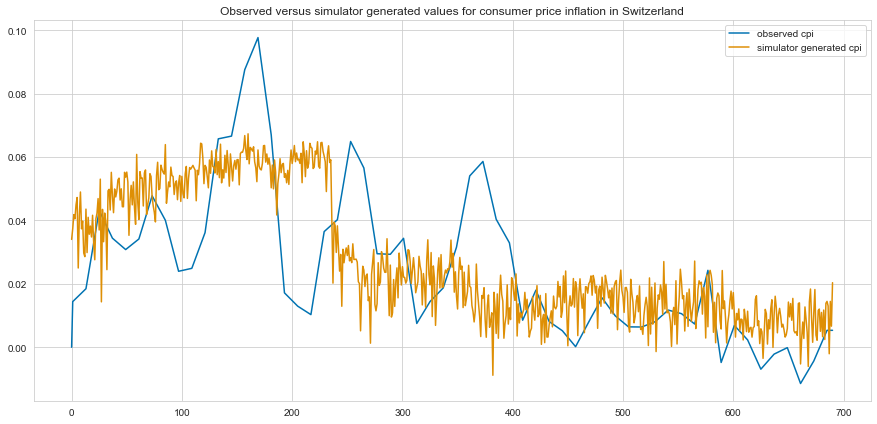

In [53]:
plt.figure(figsize=(15,7))
plt.plot(cpi, label='observed cpi')
plt.plot(generated_cpi, label='simulator generated cpi')
plt.legend()
plt.title('Observed versus simulator generated values for consumer price inflation in %s' % country)
plt.show()

In [54]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(cpi, generated_cpi)),
                                                           np.mean(cpi), np.mean(generated_cpi)))

rmse: 0.019906854648519455
mean observed: 0.025158758986210967
mean generated: 0.027913451


## Counterfactual simulation

In this simple simulation, the counterfactual conditional variable is `x` times what is found in the observed data.

In [55]:
cf_df = factual_df
cf_df['broad money'] = factual_df['broad money'] * 10.

In [56]:
cf_src, cf_src_history, cf_tar, cf_tar_history, cf_y = tt_data(len(cf_df), num_variables, params['num_timesteps'],
                                                               cf_df)

In [57]:
sim_preds = simulator.predict([cf_src, cf_src_history, cf_tar, cf_tar_history])
counterfactual_predictions = map(lambda v: v.flatten(), sim_preds[0])
cf_sim_df = pd.DataFrame(counterfactual_predictions)
cf_sim_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
count,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000,691.0000
mean,-0.0048,0.0177,0.1544,-0.0347,0.2796,0.0955,0.0208,-0.0148,0.0504,0.2380,0.2279,0.2608,0.0890,0.3504,0.8099,1.1678,11.2101,-0.0181,0.2199,6.0147,0.7297,0.0191,1.2432,0.8053,0.0794,0.0394
std,0.1591,0.1497,0.1879,0.1616,0.2182,0.1646,0.1435,0.1620,0.1597,0.2931,0.2339,0.6719,0.1991,0.4200,0.1575,0.8817,5.2953,0.1551,0.2280,0.7763,0.4895,0.1616,0.9148,0.6511,0.1527,0.1440
min,-0.5266,-0.4565,-0.3636,-0.5362,-0.3105,-0.3256,-0.6142,-0.6955,-0.4010,-0.4633,-0.3193,-2.5741,-0.4143,-0.9091,0.3630,-0.5333,2.3335,-0.5893,-0.2968,2.5571,-0.3897,-0.6100,-0.4118,-0.3896,-0.3548,-0.4653
25%,-0.1132,-0.0740,0.0115,-0.1396,0.1046,-0.0155,-0.0735,-0.1152,-0.0642,0.0423,0.0626,0.2153,-0.0457,0.1143,0.7021,0.0830,5.0839,-0.1268,0.0455,5.7259,0.2041,-0.0892,0.1460,0.0711,-0.0305,-0.0560
50%,-0.0057,0.0203,0.1505,-0.0238,0.2873,0.0829,0.0218,-0.0129,0.0465,0.1868,0.2040,0.4759,0.0765,0.3341,0.8115,1.5594,13.3802,-0.0223,0.2279,6.1343,0.9104,0.0129,1.6450,0.9958,0.0729,0.0390
75%,0.0944,0.1163,0.2830,0.0834,0.4501,0.2058,0.1125,0.0963,0.1560,0.4122,0.3836,0.6574,0.1998,0.5820,0.9225,1.8931,14.9011,0.0869,0.3880,6.4835,1.1180,0.1301,1.9641,1.3654,0.1758,0.1367
max,0.5977,0.5471,0.8560,0.5401,0.8262,0.6151,0.5146,0.4648,0.6396,1.1879,1.1023,1.1003,0.7970,1.7050,1.2719,2.3714,20.0875,0.4322,0.9285,7.8880,1.6295,0.6362,2.7297,1.9270,0.6751,0.6448


In [58]:
print(f'Average difference between counterfactual and factually generated variables mean: {np.mean(cf_sim_df.describe().iloc[1] - gen_df.describe().iloc[1])}')

Average difference between counterfactual and factually generated variables mean: 0.18608675683930442


In [59]:
print(f'Average difference between counterfactual and factually generated variables variance: {np.mean(cf_sim_df.describe().iloc[2] - gen_df.describe().iloc[2])}')

Average difference between counterfactual and factually generated variables variance: 0.18527287280908802


In [60]:
from scipy.stats import mannwhitneyu

print(f'The difference in mean between factual and counterfactual data has a p value of: {mannwhitneyu(gen_df.describe().iloc[1], cf_sim_df.describe().iloc[1], alternative="two-sided").pvalue}')
print(f'The difference in variance between factual and counterfactual data has a p value of: {mannwhitneyu(gen_df.describe().iloc[2], cf_sim_df.describe().iloc[2], alternative="two-sided").pvalue}')

The difference in mean between factual and counterfactual data has a p value of: 0.8048570913372853
The difference in variance between factual and counterfactual data has a p value of: 0.13108215992444813


In [61]:
cf_cpi = sim_preds[1]
cpi = cf_df[['label']][0:n].values

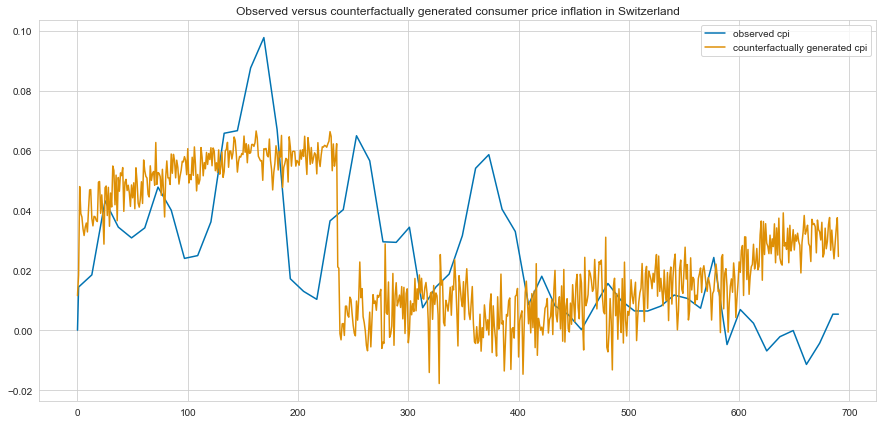

In [62]:
plt.figure(figsize=(15,7))
plt.plot(cpi, label='observed cpi')
plt.plot(cf_cpi, label='counterfactually generated cpi')
plt.legend()
plt.title('Observed versus counterfactually generated consumer price inflation in %s' % country)
plt.show()

In [63]:
print('mean observed: %s\nmean generated: %s' % (np.mean(cpi), np.mean(cf_cpi)))

mean observed: 0.025158758986210967
mean generated: 0.026614692
